# Анализ программы лояльности магазина строительных материалов

## Загрузка данных и подготовка к исследованию

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from plotly import graph_objects as go
import matplotlib
from datetime import datetime, timedelta
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None
import warnings
warnings.filterwarnings("ignore")

### Изучение общей информации

In [2]:
df = pd.read_csv('...')
df.head()

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


В таблице df содердится информация о покупках, включающая id чека, товара, его количество, дату покупки, id покупателя, id магазина и признак наличия покупателя в программе лояльности. Всего в таблице 105335 строк и 7 столбцов. Необходимо заменить названия столбцов на более удобные, заменить тип данных в столбце с датой, id покупателя и признак участия в программе лояльности. Также наблюдаем наличие пропусков в столбце с id покупателя.

In [4]:
df_codes = pd.read_csv('...')
df_codes.head()

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


In [5]:
df_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


В таблице df_codes содержится информация об id товара и его стоимости. Всего в таблице 9969 строк и 2 столбца. Необходимо заменить название столбца productID на более удобное. Пропусков не наблюдается, столбцы имеют правильные типы данных.

### Изменение названия столбцов

In [6]:
# Заменим названия столбцов в таблице df
df.columns = ['purchase_id','item_id','quantity','purchase_date','customer_id','shop_id','loyalty_program']
df.sample()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
71371,538353,84596E,71,2016-12-10 15:31:00,19477.0,Shop 0,0.0


In [7]:
# Заменим названия столбцов в таблице df_codes
df_codes.columns = ['item_id','price_per_one']
df_codes.sample()

,item_id,price_per_one
309,21063,0.85


### Обработка дубликатов

In [8]:
df.duplicated().sum()

1033

In [9]:
df_codes.duplicated().sum()

0

В таблице df обнаружено 1033 дублирующих строк, в таблице df_codes явных дубликатов не обнаружено

In [10]:
df[df.duplicated(keep=False)].sort_values(by=['purchase_id','item_id']).head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
35797,536409,21866,0,2016-12-01 11:45:00,23587.0,Shop 0,1.0
56087,536409,21866,0,2016-12-01 11:45:00,23587.0,Shop 0,1.0
22208,536409,22111,0,2016-12-01 11:45:00,23587.0,Shop 0,1.0
54076,536409,22111,0,2016-12-01 11:45:00,23587.0,Shop 0,1.0
24235,536409,22866,0,2016-12-01 11:45:00,23587.0,Shop 0,1.0


In [11]:
df[df.duplicated()].query('loyalty_program == 1.0').shape

(430, 7)

In [12]:
df[df.duplicated()]['quantity'].value_counts()

 0      693
 1      121
 5       48
 11      46
-2       38
 2       16
 3       14
 7       13
 4       12
 23      11
 9        8
 24       4
-3        2
-13       2
 6        1
 15       1
 31       1
 47       1
 143      1
Name: quantity, dtype: int64

In [13]:
df.duplicated().sum() / df.shape[0] * 100

0.9806806854321926

Дубликаты в таблице df составляют менее 1%, какой-то закономерности в наличии дублирующих строк не обнаружено, поэтому удалим эти строки. Возможно, повторяющиеся строки означают, что товар пробили ещё раз, вместо того, чтобы увеличить количество, а возможно это просто технический сбой.

In [14]:
df = df.drop_duplicates()

Проверим на наличие неявных дубликатов

In [15]:
df_codes.sort_values(by='item_id').head()

,item_id,price_per_one
31,10002,0.85
8122,10002,1.63
2459,10002,1.66
9886,10080,0.85
2432,10120,0.21


In [16]:
df_codes['item_id'].duplicated().sum()

6810

В таблице df_codes явных дубликатов не обнаружено, но есть множество неявных. Для одного товара есть несколько строчек с разной ценой. Возможно, ценник варьируется в разных филиалах сети, либо таблица включает всю историю изменений цен на товары. Для дальнейшей работы будем использвать медианное значение цен по каждому товару. Для этого создадим сводную таблицу `df_id`

In [17]:
df_id = round(df_codes.pivot_table(index='item_id', values='price_per_one', aggfunc='median'),2).reset_index()
df_id.head()

,item_id,price_per_one
0,10002,1.63
1,10080,0.85
2,10120,0.21
3,10123C,0.65
4,10124A,0.42


In [18]:
df['shop_id'].value_counts()

Shop 0     96370
Shop 4      1739
Shop 1      1540
Shop 6      1030
Shop 8       560
Shop 3       492
Shop 7       312
Shop 10      299
Shop 12      278
Shop 18      255
Shop 2       252
Shop 5       179
Shop 11      169
Shop 14      154
Shop 19       74
Shop 9        61
Shop 15       60
Shop 16       59
Shop 26       56
Shop 25       53
Shop 27       45
Shop 17       40
Shop 22       40
Shop 13       35
Shop 24       32
Shop 21       32
Shop 28       30
Shop 20       30
Shop 30       15
Shop 29        9
Shop 23        2
Name: shop_id, dtype: int64

В столбце `'shop_id'` неявных дубликатов не обнаружено.

### Обработка пропусков

In [19]:
df.isna().sum()

purchase_id            0
item_id                0
quantity               0
purchase_date          0
customer_id        36148
shop_id                0
loyalty_program        0
dtype: int64

In [20]:
df.query('loyalty_program == True')['customer_id'].isna().sum()

0

В столбце `'customer_id'` обнаружено 36148 пропусков, что составляет более 30% от всего датасета. Среди участников программы лояльности пропусков нет. Поэтому можем предположить, что пропуски - это покупатели, не имеющие карты магазина. Проверим, можно ли восстановить пропуски по имеющимся данным.

In [21]:
df[df['customer_id'].isna()].head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
6,540468,22189,0,2017-01-07 13:55:00,NaN,Shop 0,0.0
7,541424,79321,1,2017-01-17 17:57:00,NaN,Shop 0,0.0
8,538883,22891,0,2016-12-14 15:56:00,NaN,Shop 0,0.0
11,541696,22197,4,2017-01-20 18:08:00,NaN,Shop 0,0.0
16,539744,22300,5,2016-12-21 15:21:00,NaN,Shop 0,0.0


In [22]:
len(df.dropna().merge(df[df['customer_id'].isna()], on='purchase_id',how='inner'))

0

Пересечений между id чеков в строках с пропусками и в строках с заполненными id покупателей не обнаружено. Для анализа программы лояльности нам необходимо идентифицировать всех покупателей, поэтому удалим строки с пропусками в столбце `'customer_id'`

In [23]:
df = df.dropna(subset = ['customer_id'])

In [24]:
df.isna().sum()

purchase_id        0
item_id            0
quantity           0
purchase_date      0
customer_id        0
shop_id            0
loyalty_program    0
dtype: int64

In [25]:
df.shape

(68154, 7)

Таким образом, мы удалили пропуски в столбце 'customer_id' и в датафрейме осталось 68154 строки

### Изменение типов данных

In [26]:
df['purchase_date'] = pd.to_datetime(df['purchase_date'], format='%Y-%m-%d %H:%M:%S')

In [27]:
df['customer_id'] = df['customer_id'].astype('int')
df['customer_id'] = df['customer_id'].astype('str')

In [28]:
df['loyalty_program'] = df['loyalty_program'] == 1.0

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68154 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      68154 non-null  object        
 1   item_id          68154 non-null  object        
 2   quantity         68154 non-null  int64         
 3   purchase_date    68154 non-null  datetime64[ns]
 4   customer_id      68154 non-null  object        
 5   shop_id          68154 non-null  object        
 6   loyalty_program  68154 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(4)
memory usage: 3.7+ MB


Столбец `'purchase_date'` привели к типу datetime, столбец `'customer_id'` привели к типу object предварительно приведя к целым числам, столбец `'loyalty_program'` привели к булеву типу данных.

### Объединение таблиц

Объединим таблицы df и df_id по общему столбцу `'item_id'`

In [30]:
data = df.merge(df_id, on='item_id', how='left')
data.sample()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one
22863,541252,75013B,2,2017-01-16 13:41:00,18743,Shop 0,False,0.82


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68154 entries, 0 to 68153
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      68154 non-null  object        
 1   item_id          68154 non-null  object        
 2   quantity         68154 non-null  int64         
 3   purchase_date    68154 non-null  datetime64[ns]
 4   customer_id      68154 non-null  object        
 5   shop_id          68154 non-null  object        
 6   loyalty_program  68154 non-null  bool          
 7   price_per_one    68154 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 4.2+ MB


### Создание дополнительных столбцов

Создадим новый столбец `'total'` перемножив столбцы `'quantity'` и `'price_per_one'`

In [32]:
data['total'] = round(data['quantity'] * data['price_per_one'],2)
data.sample()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,total
1780,541006,21755,5,2017-01-13 10:43:00,19672,Shop 0,False,6.6,33.0


Также выделим в отдельный столбец информацию о дате покупки 'purchase_date', а столбец с датой и временем переименуем в 'purchase_datetime'

In [33]:
data['purchase_datetime'] = data['purchase_date']
data['purchase_date'] = data['purchase_date'].dt.date
data['purchase_date'] = pd.to_datetime(data['purchase_date'], format='%Y-%m-%d')

### Обработка аномальных значений и выбросов

In [34]:
data.describe()

,quantity,price_per_one,total
count,68154.000000,68154.000000,68154.000000
mean,11.119890,4.557684,29.183700
std,406.602498,6.961422,456.609132
min,-74216.000000,0.060000,-77184.640000
25%,1.000000,1.860000,2.460000
50%,4.000000,3.120000,12.460000
75%,11.000000,5.790000,27.060000
max,74214.000000,265.500000,77182.560000


Начнём со столбца **`'quantity'`**. По таблице видим, что при медиане всего в 4 единицы и третьем квартиле в 11 единиц, минимум и максимум в тысячи раз отличается от этих значений. Рассмотрим подробнее на графике.

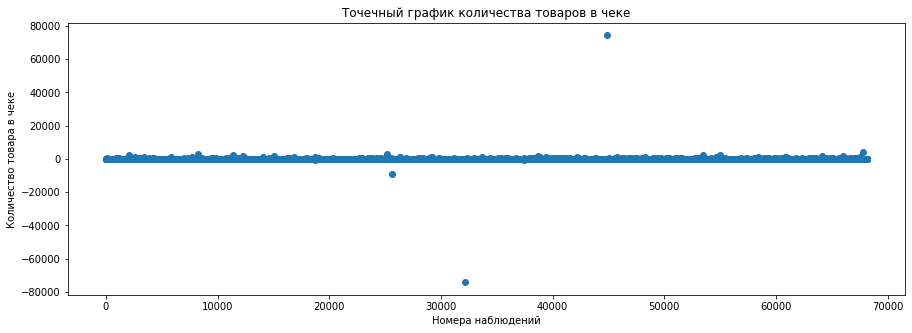

In [35]:
x_values = pd.Series(range(0,len(data)))
plt.figure(figsize=(15, 5))
plt.scatter(x_values, data['quantity'])
plt.title('Точечный график количества товаров в чеке')
plt.xlabel('Номера наблюдений')
plt.ylabel('Количество товара в чеке')
plt.show()

In [36]:
np.percentile(data['quantity'], [90, 95, 99])

array([ 23.,  35., 119.])

In [37]:
np.percentile(data['quantity'], [10, 5, 1])

array([ 0.,  0., -4.])

На графике видим сильно выбивающиеся значения -74216 и 74214, при этом 98% выборки находится в интервале от -4 до 119. Очистим выборку от аномальных значений по перцентилям 1 и 99.

In [38]:
data = (
    data[(data['quantity'] >= np.percentile(data['quantity'], 1)) 
         & (data['quantity'] <= np.percentile(data['quantity'], 99))]
)
data.shape

(66865, 10)

In [39]:
round(data.shape[0] / df.shape[0] * 100 - 100, 2)

-1.89

Размер выборки уменьшился на 1,89%. Рассмотрим ещё отрицательные значения в столбце `'quantity'`

In [40]:
data[data['quantity'] < 0].shape[0]

1151

In [41]:
data[data['quantity'] < 0].head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,total,purchase_datetime
46,C539944,22776,-2,2016-12-23,20239,Shop 0,False,14.96,-29.92,2016-12-23 11:38:00
77,C542910,20726,-2,2017-02-01,23190,Shop 0,True,4.13,-8.26,2017-02-01 15:38:00
223,C544034,21878,-2,2017-02-15,20380,Shop 0,False,1.24,-2.48,2017-02-15 11:28:00
429,C537602,22423,-3,2016-12-07,23190,Shop 0,True,12.74,-38.22,2016-12-07 12:45:00
516,C539644,21577,-2,2016-12-20,18150,Shop 4,False,4.96,-9.92,2016-12-20 15:52:00


Всего в столбце 'quantity' 1151 отрицательных значений, в id чека с отрицательными значениями появилась буква С, возможно тут есть какая-то закономерность.

In [42]:
display(
    data['purchase_id'].str.contains('C').sum(),
    
    data[(data['purchase_id'].str.contains('C')) & (data['quantity'] < 0)].shape[0]
)

1151

1151

С буквой С обнаружена 1151 строка и во всех этих строках 'quantity' меньше нуля. Посмотрим на несколько примеров с отрицательными значениями

In [43]:
data[(data['item_id'] == '22776') & (data['customer_id'] == '20239')]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,total,purchase_datetime
46,C539944,22776,-2,2016-12-23,20239,Shop 0,False,14.96,-29.92,2016-12-23 11:38:00
33094,539326,22776,11,2016-12-17,20239,Shop 0,False,14.96,164.56,2016-12-17 09:22:00
57702,542351,22776,11,2017-01-27,20239,Shop 0,False,14.96,164.56,2017-01-27 12:13:00


In [44]:
data[(data['item_id'] == '20726') & (data['customer_id'] == '23190')]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,total,purchase_datetime
77,C542910,20726,-2,2017-02-01,23190,Shop 0,True,4.13,-8.26,2017-02-01 15:38:00


In [45]:
data[(data['item_id'] == '21878') & (data['customer_id'] == '20380')]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,total,purchase_datetime
223,C544034,21878,-2,2017-02-15,20380,Shop 0,False,1.24,-2.48,2017-02-15 11:28:00


In [46]:
data[(data['item_id'] == '22423') & (data['customer_id'] == '23190')]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,total,purchase_datetime
429,C537602,22423,-3,2016-12-07,23190,Shop 0,True,12.74,-38.22,2016-12-07 12:45:00
67044,C542910,22423,-3,2017-02-01,23190,Shop 0,True,12.74,-38.22,2017-02-01 15:38:00


In [47]:
data[data['quantity'] < 0].groupby('loyalty_program').agg({'total':'sum'})

,total
loyalty_program,
False,-15692.53
True,-7165.31


Есть предположение, что буква С означает отмену (cancel), возврат товара, но в наших данных по некоторым покупателям есть только возвраты, но нет покупок. Возможно покупки были соверешены в более ранние периоды. Для избежания путаницы в дальнейших расчетах будем использовать только положительные quantity

In [48]:
data = data[data['quantity'] >= 0]
round(data.shape[0] / df.shape[0] * 100 - 100, 2)

-3.58

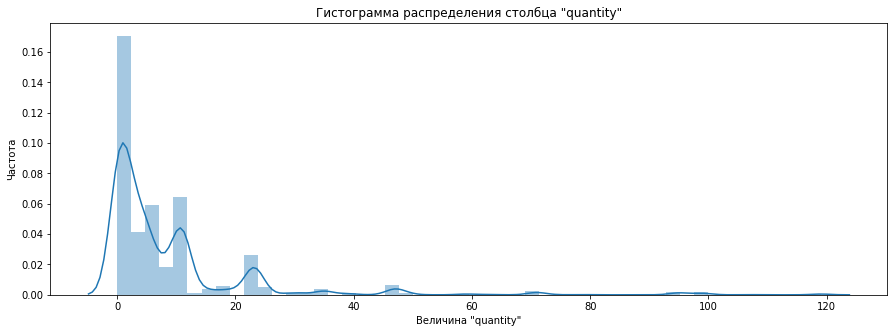

In [49]:
plt.figure(figsize=(15, 5))
sns.distplot(data['quantity'])
plt.title('Гистограмма распределения столбца "quantity"')
plt.xlabel('Величина "quantity"')
plt.ylabel('Частота')
plt.show()

В столбце "quantity" также отмечается всплеск значений в районе 0. Рассмотрим эти строки подробнее

In [50]:
data[data['quantity'] == 0].shape

(12482, 10)

In [51]:
data[data['quantity'] == 0].pivot_table(
    index = 'purchase_id', values='quantity', aggfunc='count', columns = 'loyalty_program').head()

loyalty_program,False,True
purchase_id,,
536381,13.0,NaN
536385,NaN,1.0
536392,1.0,NaN
536401,35.0,NaN
536403,1.0,NaN


In [52]:
# Посчитаем количество уникальных товаров, среди которых встречаются нулевые значения,
# и сколько всего уникальных товаров в датасете
display(data[data['quantity'] == 0]['item_id'].nunique(),
data['item_id'].nunique())

2107

2755

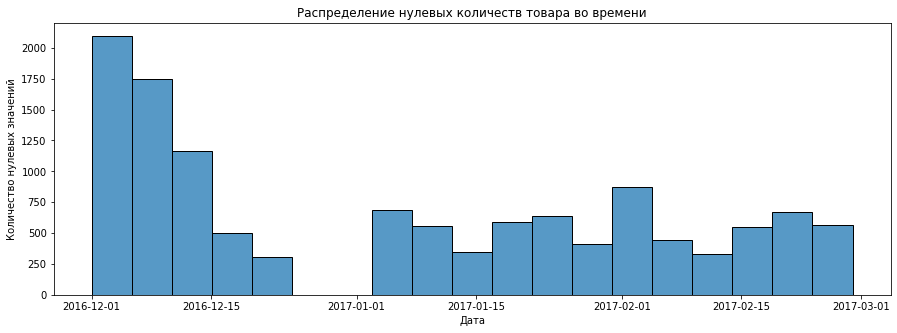

In [53]:
plt.figure(figsize=(15, 5))
sns.histplot(data[data['quantity'] == 0]['purchase_date'])
plt.title('Распределение нулевых количеств товара во времени')
plt.xlabel('Дата')
plt.ylabel('Количество нулевых значений')
plt.show()

Нулевые строки составляют весомую долю датасета и встречаются у покупателей как участвующих, так и не участвующих в программе лояльности. При этом нет признаков наличия какого-то сбоя, нулевые значения встречаются на протяжении всего периода в большинстве товарных позиций. Возможно, так обозначается акционный товар, идущий в подарок. Оставим нули без изменений.

Далее рассмотрим столбец **`'price_per_one'`**. 

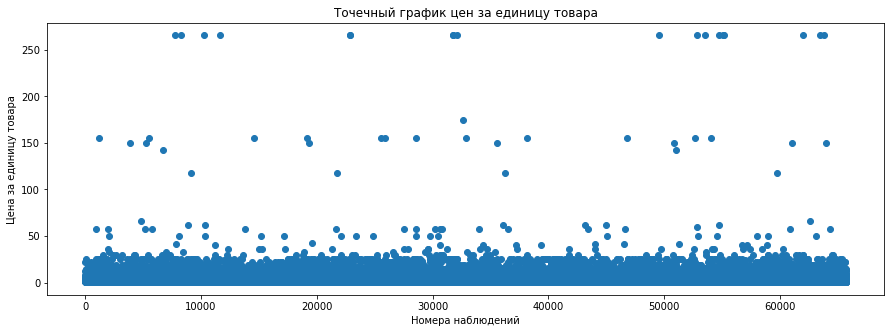

In [54]:
x_values = pd.Series(range(0,len(data)))
plt.figure(figsize=(15, 5))
plt.scatter(x_values, data['price_per_one'])
plt.title('Точечный график цен за единицу товара')
plt.xlabel('Номера наблюдений')
plt.ylabel('Цена за единицу товара')
plt.show()

На графике отсутствуют явно выбивающиеся значения, большинство цен колеблется в пределах 50 рублей, но есть и более дорогостоящий товар со стоимостью чуть более 250 рублей.

Рассмотрим столбец **`'total'`**. 

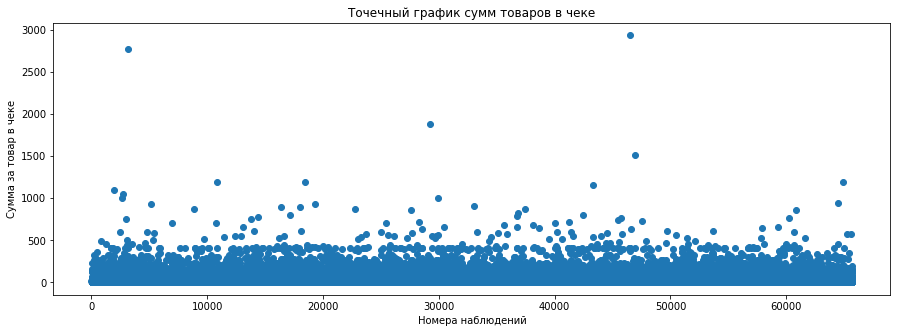

In [55]:
x_values = pd.Series(range(0,len(data)))
plt.figure(figsize=(15, 5))
plt.scatter(x_values, data['total'])
plt.title('Точечный график сумм товаров в чеке')
plt.xlabel('Номера наблюдений')
plt.ylabel('Сумма за товар в чеке')
plt.show()

In [56]:
data[data['total'] > 1500]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,total,purchase_datetime
3265,541220,22838,95,2017-01-14,19835,Shop 6,False,29.17,2771.15,2017-01-14 14:11:00
30244,538063,22830,95,2016-12-09,23781,Shop 0,True,19.84,1884.80,2016-12-09 13:44:00
48195,537659,22833,71,2016-12-07,23781,Shop 0,True,41.32,2933.72,2016-12-07 16:43:00
48622,536970,22423,119,2016-12-03,23628,Shop 0,True,12.74,1516.06,2016-12-03 13:12:00


На графике видно четыре выбивающихся значения с суммой более 1500 рублей, но оснований удалять эти строки нет, т.к выше мы уже избавились от аномальных значений в столбцах, формирующих столбец total.

In [57]:
data.describe()

,quantity,price_per_one,total
count,65714.000000,65714.000000,65714.000000
mean,8.873376,4.515067,25.637550
std,14.830603,6.673490,54.145938
min,0.000000,0.060000,0.000000
25%,1.000000,1.860000,2.950000
50%,4.000000,3.100000,12.630000
75%,11.000000,5.790000,27.060000
max,119.000000,265.500000,2933.720000


Таким образом, мы очистили датасет от аномалий, удалив суммарно 3,6% строк от первоначального размера.

## Исследовательский анализ данных

### Определение временного периода анализа

In [58]:
print(f'В датасете представлены данные с {data["purchase_date"].min()} по {data["purchase_date"].max()}')

В датасете представлены данные с 2016-12-01 00:00:00 по 2017-02-28 00:00:00


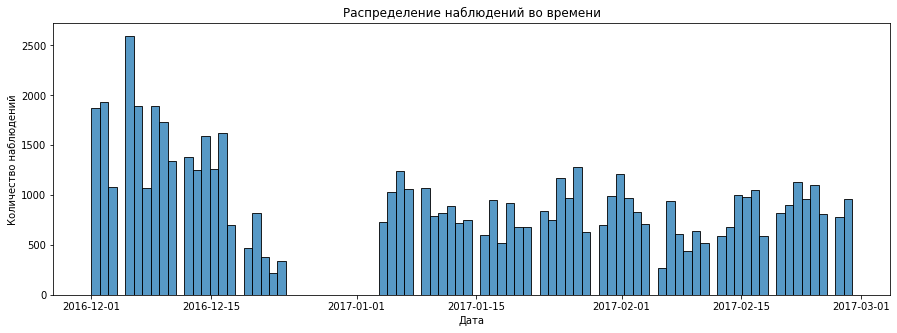

In [59]:
plt.figure(figsize=(15, 5))
sns.histplot(data['purchase_date'], bins=90)
plt.title('Распределение наблюдений во времени')
plt.xlabel('Дата')
plt.ylabel('Количество наблюдений')
plt.show()

Для анализа представлены данные за три месяца с декабря 2016 года по февраль 2017 года включительно. На графике видно, что в данных есть пробелы в конце декабря и начале января, что скорее всего обусловлено новогодними праздниками, плюс у магазина выходной по воскресеньям.

### Анализ данных о товарах

In [60]:
(
    print(f'''За три месяца было продано {data["quantity"].sum()} товаров {data["item_id"].nunique()} уникальных наименований,
что составляет {round(data["item_id"].nunique() / df_id.shape[0]*100,2)}% от всего ассортимента товаров магазина''')
)

За три месяца было продано 583105 товаров 2755 уникальных наименований,
что составляет 87.21% от всего ассортимента товаров магазина


In [61]:
data.groupby('item_id').agg({'quantity' : 'sum'}).sort_values(by='quantity', ascending=False).reset_index().head()

,item_id,quantity
0,21212,5723
1,85123A,5520
2,85099B,5508
3,84879,3587
4,22469,3529


Топ-3 товаров по количеству продаж: "21212" - 5723 штуки, "85123A" - 5520 штук, "85099B" - 5508 штук.

In [62]:
data_item = (
    data.pivot_table(index='purchase_date', values='quantity', aggfunc='sum')
    .reset_index()
    .sort_values(by='quantity', ascending=False)
)
data_item.head()

,purchase_date,quantity
13,2016-12-16,18874
1,2016-12-02,18525
6,2016-12-08,16429
0,2016-12-01,16358
22,2017-01-06,15671


In [63]:
data_item.tail()

,purchase_date,quantity
42,2017-01-30,2686
30,2017-01-16,2636
18,2016-12-22,2459
54,2017-02-13,1985
48,2017-02-06,1620


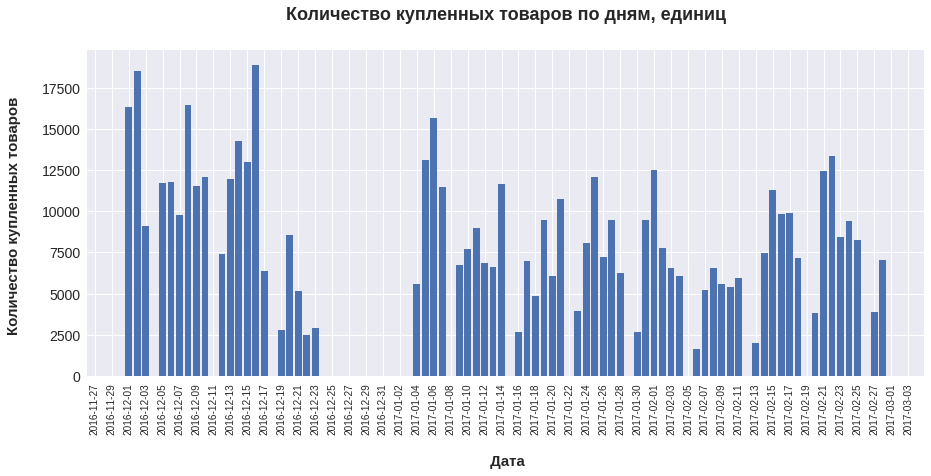

In [64]:
plt.figure(figsize=(15,6))
with plt.style.context('seaborn'):
    plt.bar(data_item['purchase_date'], data_item['quantity'])
    plt.title(
        "Количество купленных товаров по дням, единиц", 
        fontsize = 18, 
        fontweight='bold', 
        pad=30)
    plt.xlabel("\n Дата", fontsize = 15, fontweight='bold')
    plt.ylabel("Количество купленных товаров \n ", fontsize = 15, fontweight='bold')
    plt.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 14)
    plt.xticks(rotation=90)
    plt.show()

Больше всего товаров было куплено 16 декабря 2016 года - 18874 единиц, меньше всего - 6 февраля 2017 года - 1620 единиц товара. В целом в декабре 2016 года отмечалась большая активность в покупке товаров, чем в январе и феврале 2017 года

### Анализ данных о покупателях

In [65]:
print(f'Всего за рассматриваемый период магазин посетило {data["customer_id"].nunique()} уникальных покупателей')

Всего за рассматриваемый период магазин посетило 1661 уникальных покупателей


In [66]:
data_cust = (
    data.groupby(['customer_id', 'loyalty_program'])
    .agg({'purchase_id' : 'nunique'})
    .reset_index()
)

In [67]:
data_cust.describe()

,purchase_id
count,1661.000000
mean,1.989163
std,2.420769
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,44.000000


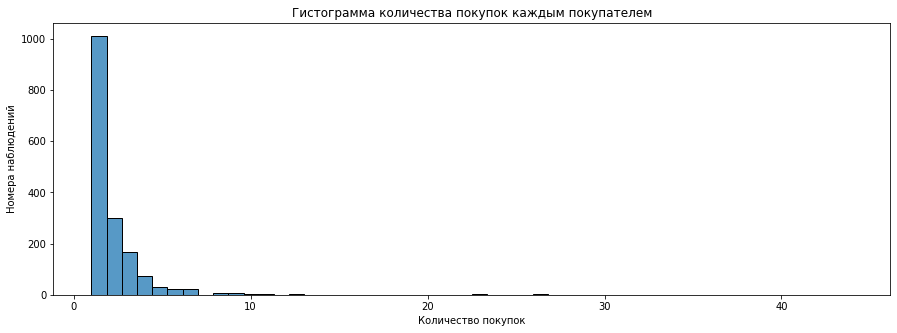

In [68]:
plt.figure(figsize=(15, 5))
sns.histplot(data_cust['purchase_id'], bins=50)
plt.title('Гистограмма количества покупок каждым покупателем')
plt.xlabel('Количество покупок')
plt.ylabel('Номера наблюдений')
plt.show()

In [69]:
data_cust[data_cust['purchase_id'] > 10].shape[0]

15

В среднем покупатели совершали около двух покупок в магазине, медианное значение составляет одну покупку. Встречаются также покупатели (15 человек), совершившие больше десятка покупок за рассматриваемый период.

### Анализ данных о магазинах

In [70]:
data_shop = (
    data.pivot_table(index='shop_id', values='purchase_id', aggfunc='nunique')
    .sort_values(by='purchase_id', ascending=False).reset_index()
)
data_shop['%_of_total'] = round(data_shop['purchase_id'] / data['purchase_id'].nunique() * 100,2)
data_shop.head()

,shop_id,purchase_id,%_of_total
0,Shop 0,2985,90.35
1,Shop 4,80,2.42
2,Shop 1,71,2.15
3,Shop 6,31,0.94
4,Shop 2,17,0.51


In [71]:
print(f'Всего в датасете представлено {data_shop.shape[0]} филиалов магазина строительных материалов')

Всего в датасете представлено 29 филиалов магазина строительных материалов


Самый крупный филиал сети - магазин Shop 0, на долю которого приходится 90% всех покупок за рассматриваемый период. Посмотрим, как распределены покупки по другим филиалам на графике.

In [72]:
data_shop_2 = data_shop[data_shop['shop_id'] != 'Shop 0']

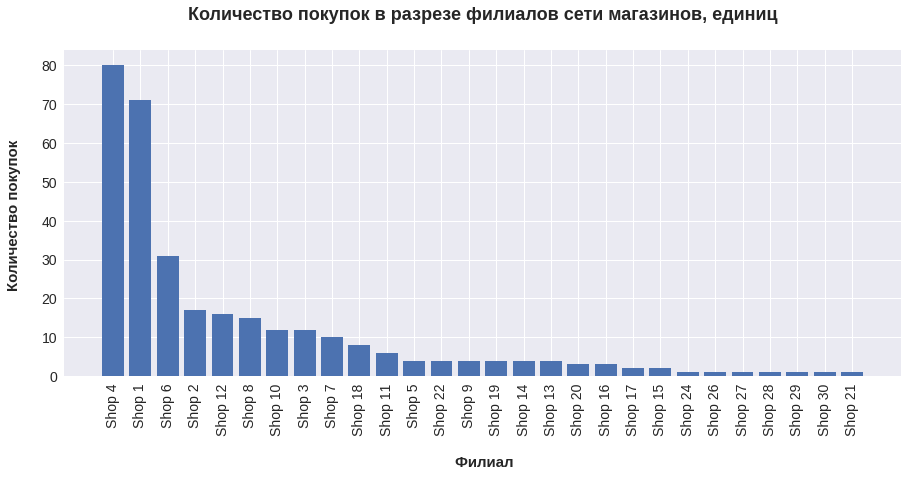

In [73]:
plt.figure(figsize=(15,6))
with plt.style.context('seaborn'):
    plt.bar(data_shop_2['shop_id'], data_shop_2['purchase_id'])
    plt.title(
        "Количество покупок в разрезе филиалов сети магазинов, единиц", 
        fontsize = 18, 
        fontweight='bold', 
        pad=30)
    plt.xlabel("\n Филиал", fontsize = 15, fontweight='bold')
    plt.ylabel("Количество покупок \n ", fontsize = 15, fontweight='bold')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xticks(rotation=90)
    plt.show()

После Shop 0 по количеству покупок следуют Shop 4 (80 покупок, или 2,4%) и Shop 1 (71, или 2,2%). В 19 филиалах из 29 было совершено менее 10 покупок.

### Анализ данных об участии в программе лояльности

In [74]:
data_lo = data.groupby('loyalty_program').agg({'customer_id' : 'nunique'}).reset_index()
data_lo

,loyalty_program,customer_id
0,False,1105
1,True,556


In [ ]:
fig = go.Figure(data=[go.Pie(labels=data_lo['loyalty_program'], 

                             values=data_lo['customer_id'], 

                             pull = [0.1, 0])]
               )

fig.update_layout(title='Соотношение покупателей по признаку вхождения в систему лояльности', 

                  width=700, 

                  height=500,

                  annotations=[dict(x=1.15, 

                                    y=1.05,

                                    text='Вхождение покупателя в систему лояльности',

                                    showarrow=False)], piecolorway =["#00A08B", "#EB663B"])

fig.show()

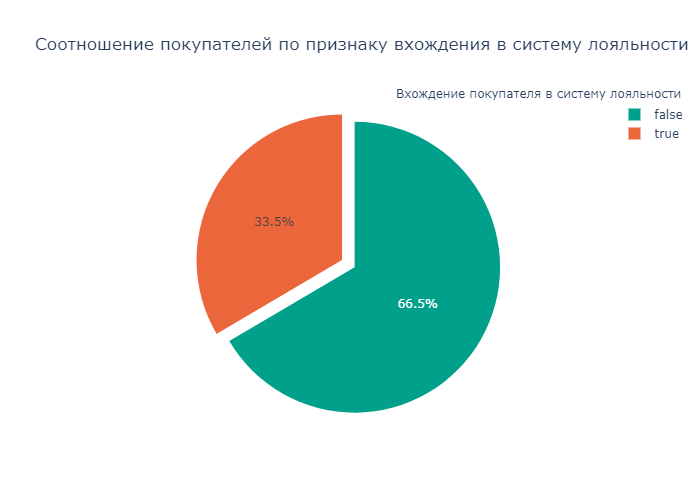

В программе лояльности приняли участие треть покупателей за рассматриваемый период.

## Анализ программы лояльности

### Расчет ритейл-метрик в разрезе когорт: клиенты внутри программы лояльности и вне её

#### Средний чек

In [76]:
data_group = (
    data.groupby('purchase_id')
    .agg({'item_id': 'nunique', 'quantity': 'sum', 'purchase_date': 'max', 'customer_id': 'first', \
          'shop_id': 'max', 'total': 'sum', 'loyalty_program' : 'first'})
    .reset_index())
data_group.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,total,loyalty_program
0,536365,7,33,2016-12-01,23529,Shop 0,186.50,True
1,536366,2,10,2016-12-01,23529,Shop 0,19.80,True
2,536367,12,71,2016-12-01,18726,Shop 0,285.49,False
3,536368,4,11,2016-12-01,18726,Shop 0,96.09,False
4,536369,1,2,2016-12-01,18726,Shop 0,13.20,False


In [77]:
# Добавим столбец с месяцем покупки
data_group['purchase_month'] = data_group['purchase_date'].astype('datetime64[M]')
data_group.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,total,loyalty_program,purchase_month
0,536365,7,33,2016-12-01,23529,Shop 0,186.50,True,2016-12-01
1,536366,2,10,2016-12-01,23529,Shop 0,19.80,True,2016-12-01
2,536367,12,71,2016-12-01,18726,Shop 0,285.49,False,2016-12-01
3,536368,4,11,2016-12-01,18726,Shop 0,96.09,False,2016-12-01
4,536369,1,2,2016-12-01,18726,Shop 0,13.20,False,2016-12-01


In [78]:
# Посчитаем средний чек за весь период
round(data_group.groupby('loyalty_program').agg({'total' : 'mean'}), 2)

,total
loyalty_program,
False,559.28
True,411.26


За весь рассматриваемый период средний чек покупателей по программе лояльности меньше на 148 рублей. Рассмотрим, как менялся показатель в динамике

In [79]:
data_avg_check = (
    round(data_group.pivot_table(index='purchase_date', columns='loyalty_program', values='total', aggfunc='mean'),2)
)
data_avg_check.head()

loyalty_program,False,True
purchase_date,,
2016-12-01,488.00,301.68
2016-12-02,495.25,281.89
2016-12-03,651.86,404.94
2016-12-05,415.26,354.94
2016-12-06,376.12,294.87


In [ ]:
fig = px.bar(
    data_avg_check, x=data_avg_check.index, y=[False, True], color_discrete_sequence=["#00A08B", "#EB663B"],barmode='group'
)

fig.update_layout(xaxis={'categoryorder':'total descending'}, 
                  title="Средний чек в разбивке на группы покупателей по признаку участия в программе лояльности",
                  yaxis_title="Размер среднего чека",
                  xaxis_title="Дата")
fig.show() 

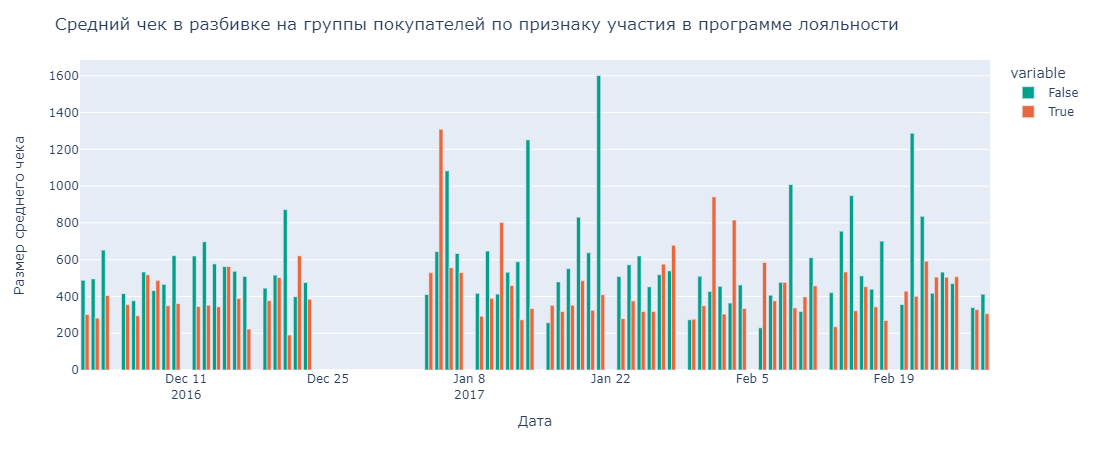

В декабре и январе, за исключением нескольких дней, средний чек участников программы лояльности был стабильно ниже, чем у остальных покупателей. В первую неделю февраля отмечается всплеск величины среднего чека покупателей по программе лояльности относительно остальных покупателей, а затем снова становится меньше.

In [81]:
# Сгруппируем информацию по месяцам
data_group_month = (
    data_group.groupby(['purchase_month', 'loyalty_program'])
    .agg({'customer_id':'nunique','purchase_id' : 'count', 'item_id': 'sum', 'quantity': 'sum','total': 'sum'}).reset_index()
)
data_group_month['total'] = round(data_group_month['total'],2)
data_group_month['avg_total'] = round(data_group_month['total'] / data_group_month['purchase_id'],2)
data_group_month

,purchase_month,loyalty_program,customer_id,purchase_id,item_id,quantity,total,avg_total
0,2016-12-01,False,554,865,15708,152054,449994.31,520.22
1,2016-12-01,True,316,499,9359,59066,184539.00,369.82
2,2017-01-01,False,506,684,14209,148030,423898.03,619.73
3,2017-01-01,True,227,284,6369,46387,123036.71,433.23
4,2017-02-01,False,493,653,12576,124193,357649.39,547.70
5,2017-02-01,True,252,319,6710,53375,145628.52,456.52


In [ ]:
fig = px.bar(
    data_group_month, 
    x='purchase_month', 
    y='avg_total', 
    color='loyalty_program', 
    text='avg_total',
    barmode='group',
    hover_data=['purchase_month','avg_total','loyalty_program'],
    color_discrete_sequence=["#00A08B", "#EB663B"]
)
fig.update_layout( 
                  title="Средний чек в разбивке на группы покупателей по признаку участия в программе лояльности",
                  yaxis_title="Средний чек",
                  xaxis_title="Месяц"
)
fig.show()

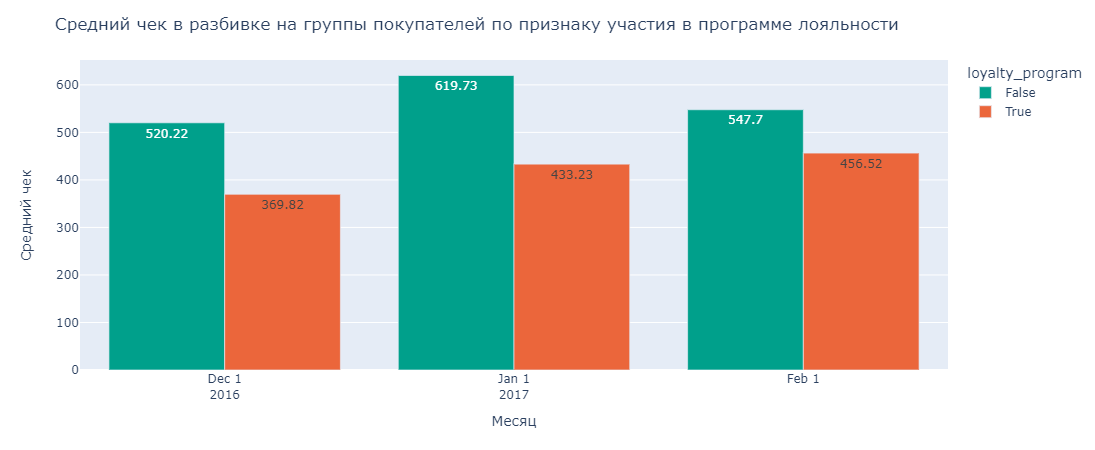

В разбивке по месяцам также видим, что средний чек покупателей по программе лояльности меньше среднего чека остальных покупателей, но при этом отмечается тенденция по его увеличению.

#### Среднее количество покупок

In [83]:
data_group_month['avg_purchase'] = round(data_group_month['purchase_id'] / data_group_month['customer_id'],2)

In [ ]:
fig = px.bar(
    data_group_month, 
    x='purchase_month', 
    y='avg_purchase', 
    color='loyalty_program', 
    text='avg_purchase',
    barmode='group',
    hover_data=['purchase_month','avg_purchase','loyalty_program'],
    color_discrete_sequence=["#00A08B", "#EB663B"]
)
fig.update_layout( 
                  title="Среднее количество покупок в разбивке на группы покупателей",
                  yaxis_title="Среднее количество покупок",
                  xaxis_title="Месяц")
fig.show()

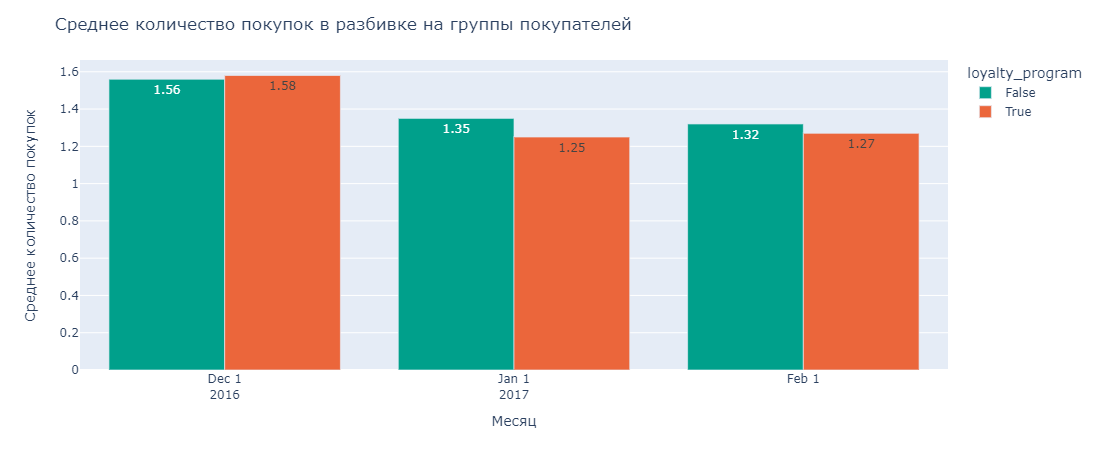

В декабре количество покупок для покупателей в группе лояльности было на 0,02 единицы выше остальных покупателей, в январе и феврале показатель для группы лояльности был меньше на 0,1 и 0,05 единицы соответственно.

#### Среднее количество наименований товаров в чеке

In [85]:
data_group_month['avg_item'] = round(data_group_month['item_id'] / data_group_month['purchase_id'],2)

In [ ]:
fig = px.bar(
    data_group_month, 
    x='purchase_month', 
    y='avg_item', 
    color='loyalty_program', 
    text='avg_item',
    barmode='group',
    hover_data=['purchase_month','avg_item','loyalty_program'],
    color_discrete_sequence=["#00A08B", "#EB663B"])
fig.update_layout( 
                  title="Среднее количество наименований товаров в чеке в разбивке на группы покупателей",
                  yaxis_title="Среднее количество наименований товаров в чеке",
                  xaxis_title="Месяц"
)
fig.show()

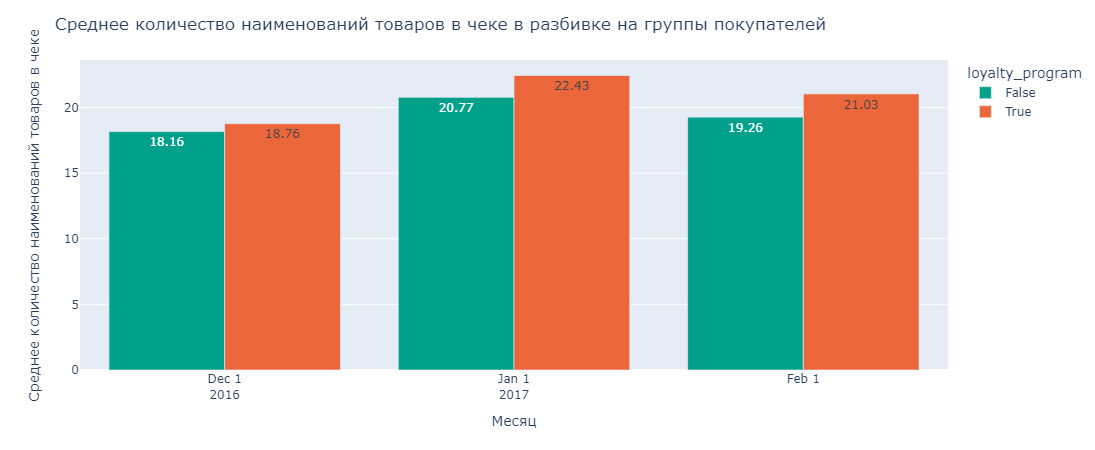

У покупателей, участвующих в группе лояльности, больше наименований товаров в чеке за весь рассматриваемый период, наибольший показатель для обеих групп отмечался в январе 2017 года.

#### Среднее количество товаров в чеке

In [87]:
data_group_month['avg_quantity'] = round(data_group_month['quantity'] / data_group_month['purchase_id'],2)

In [ ]:
fig = px.bar(
    data_group_month, 
    x='purchase_month', 
    y='avg_quantity', 
    color='loyalty_program', 
    text='avg_quantity',
    barmode='group',
    hover_data=['purchase_month','avg_quantity','loyalty_program'],
    color_discrete_sequence=["#00A08B", "#EB663B"])
fig.update_layout( 
                  title="Среднее количество товаров в чеке в разбивке на группы покупателей",
                  yaxis_title="Среднее количество товаров в чеке",
                  xaxis_title="Месяц"
)
fig.show()

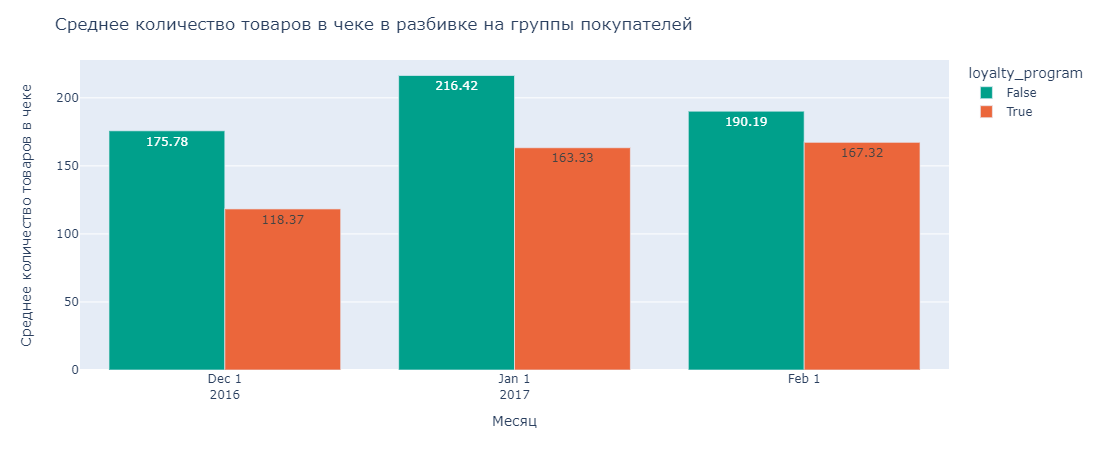

Несмотря на то, что у покупателей группы лояльности больше наименований товаров в чеке, суммарное количество товаров в чеке выше у покупателей, не пользующихся программой лояльности

#### Cредняя сумма расходов одного покупателя

In [89]:
data_group_month['avg_cust_total'] = round(data_group_month['total'] / data_group_month['customer_id'],2)

In [ ]:
fig = px.bar(
    data_group_month, 
    x='purchase_month', 
    y='avg_cust_total', 
    color='loyalty_program', 
    text='avg_cust_total',
    barmode='group',
    hover_data=['purchase_month','avg_cust_total','loyalty_program'],
    color_discrete_sequence=["#00A08B", "#EB663B"])
fig.update_layout( 
                  title="Cредняя сумма расходов одного покупателя",
                  yaxis_title="Cредняя сумма расходов одного покупателя",
                  xaxis_title="Месяц"
)
fig.show()

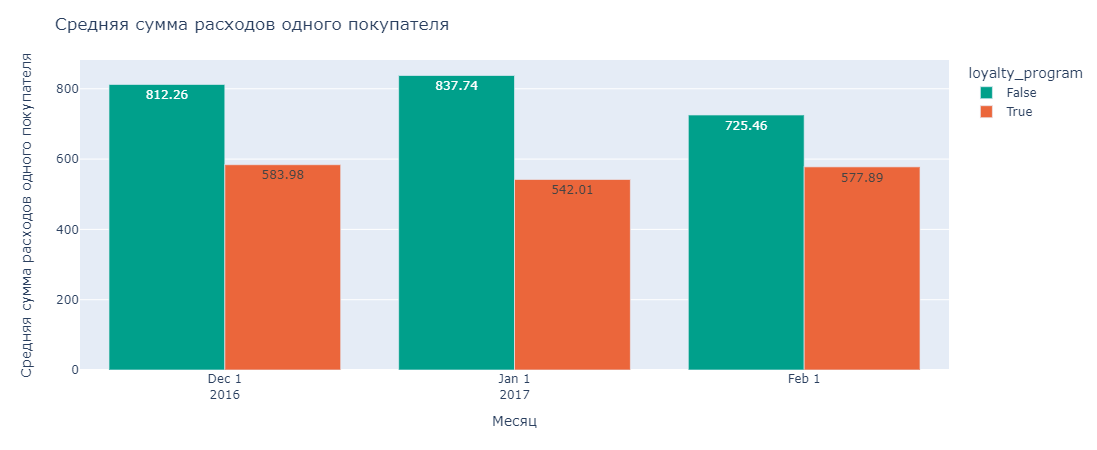

Покупатели, входящие в программу лояльности, в среднем тратят меньше денег, разница с остальными покупателями составляет от 150 до 290 рублей.

#### Расчёт LTV

In [91]:
# Зададим функцию для расчёта LTV
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем покупателей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # добавляем данные о выручке в профили
    result_raw = result_raw.merge(
        purchases[['customer_id', 'event_dt', 'revenue']],
        on='customer_id',
        how='left',
    )

    # вычисляем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['dt']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',
            aggfunc='sum',
        )
        # считаем сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'customer_id': 'nunique'})
            .rename(columns={'customer_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV:
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time


In [92]:
# Зададдим функцию для получения профилей покупателей для функции LTV
def get_profiles(data):

    profiles = (
        data.sort_values(by=['customer_id', 'purchase_datetime'])
        .groupby('customer_id')
        .agg({'purchase_datetime': 'first', 'loyalty_program': 'first'})
        .rename(columns={'purchase_datetime': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    return profiles

In [93]:
profiles = get_profiles(data)
profiles.head()

,customer_id,first_ts,loyalty_program,dt,month
0,18026,2016-12-07 14:57:00,False,2016-12-07,2016-12-01
1,18027,2016-12-16 19:09:00,False,2016-12-16,2016-12-01
2,18029,2017-02-02 16:01:00,False,2017-02-02,2017-02-01
3,18031,2017-02-16 12:33:00,False,2017-02-16,2017-02-01
4,18035,2017-01-18 09:50:00,False,2017-01-18,2017-01-01


In [94]:
profiles['dt'] = pd.to_datetime(profiles['dt'], format='%Y-%m-%d')

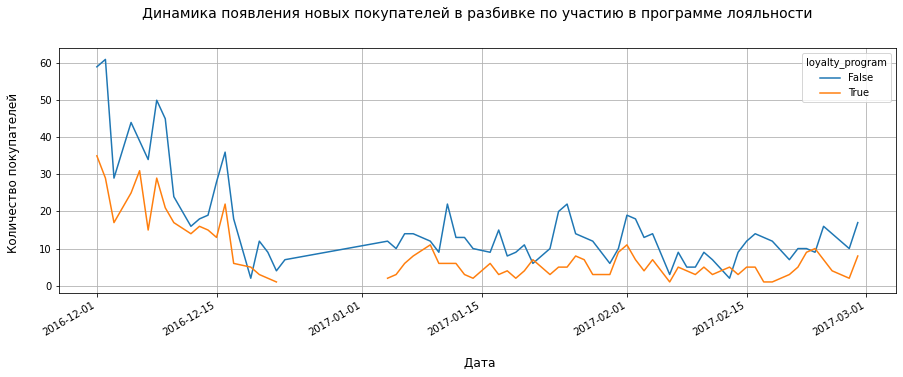

In [95]:
%matplotlib inline

profiles.pivot_table(
    index='dt',  
    columns='loyalty_program',  
    values='customer_id',  
    aggfunc='nunique'  
).plot(figsize=(15, 5), grid=True)
plt.title(
    "Динамика появления новых покупателей в разбивке по участию в программе лояльности", 
    fontsize = 14, 
    pad=30)
plt.xlabel("\n Дата", fontsize = 12)
plt.ylabel("Количество покупателей \n ", fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

В декабре отмечалось появление до 35 новых покупателей по программе лояльности и до 60 остальных покупателей, в январе и феврале в основном ежедневно появлялось до 10 покупателей по программе лояльности и от 5 до 20 остальных покупателей.

In [96]:
# Создадим таблицу с информацией о покупках для функции LTV
purchases = (
        data.sort_values(by=['customer_id', 'purchase_date'])
        .groupby(['customer_id','purchase_date'])
        .agg({'total': 'sum', 'loyalty_program': 'first'}).reset_index()
    .rename(columns={'purchase_date': 'event_dt', 'total': 'revenue'})
)
purchases.head()

,customer_id,event_dt,revenue,loyalty_program
0,18026,2016-12-07,955.36,False
1,18026,2017-01-26,781.38,False
2,18027,2016-12-16,1314.68,False
3,18027,2017-01-25,28.75,False
4,18029,2017-02-02,386.40,False


In [97]:
purchases.tail()

,customer_id,event_dt,revenue,loyalty_program
3031,23939,2017-01-09,741.93,True
3032,23948,2016-12-08,180.73,True
3033,23962,2017-01-06,12.52,True
3034,23962,2017-01-23,39.15,True
3035,23962,2017-02-28,53.20,True


In [98]:
purchases['month'] = purchases['event_dt'].astype('datetime64[M]')

В расчете LTV учтем стоимость участия в программе лояльности: 200 рублей в месяц

In [99]:
if purchases.loc[0,'loyalty_program'] == True:
    purchases.loc[0,'revenue'] += 200

In [100]:
for i in range(1, len(purchases)):
    if purchases.loc[i,'loyalty_program'] == True:
        
        if (purchases.loc[i-1,'customer_id'] == purchases.loc[i,'customer_id']) & \
        (purchases.loc[i-1,'month'] != purchases.loc[i,'month']):
            purchases.loc[i,'revenue'] += 200
        if purchases.loc[i-1,'customer_id'] != purchases.loc[i,'customer_id']:
            purchases.loc[i,'revenue'] += 200

In [101]:
purchases.head()

,customer_id,event_dt,revenue,loyalty_program,month
0,18026,2016-12-07,955.36,False,2016-12-01
1,18026,2017-01-26,781.38,False,2017-01-01
2,18027,2016-12-16,1314.68,False,2016-12-01
3,18027,2017-01-25,28.75,False,2017-01-01
4,18029,2017-02-02,386.40,False,2017-02-01


In [102]:
purchases.tail()

,customer_id,event_dt,revenue,loyalty_program,month
3031,23939,2017-01-09,941.93,True,2017-01-01
3032,23948,2016-12-08,380.73,True,2016-12-01
3033,23962,2017-01-06,212.52,True,2017-01-01
3034,23962,2017-01-23,39.15,True,2017-01-01
3035,23962,2017-02-28,253.20,True,2017-02-01


In [103]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3036 entries, 0 to 3035
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      3036 non-null   object        
 1   event_dt         3036 non-null   datetime64[ns]
 2   revenue          3036 non-null   float64       
 3   loyalty_program  3036 non-null   bool          
 4   month            3036 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(1), object(1)
memory usage: 98.0+ KB


In [104]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661 entries, 0 to 1660
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      1661 non-null   object        
 1   first_ts         1661 non-null   datetime64[ns]
 2   loyalty_program  1661 non-null   bool          
 3   dt               1661 non-null   datetime64[ns]
 4   month            1661 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](3), object(1)
memory usage: 53.7+ KB


In [105]:
observation_date = profiles['dt'].max()  # момент анализа
horizon_days = 60 # горизонт анализа

In [106]:
ltv_raw, ltv, ltv_history = get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=['loyalty_program'],
    ignore_horizon=False,
)

In [107]:
# Зададим функцию для отрисовки графиков LTV
def plot_ltv_roi(ltv, ltv_history, horizon_days, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon_days - 1]]

    
    # первый график — кривые ltv
    ax1 = plt.subplot(1, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon_days - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon_days))

    
    plt.tight_layout()
    plt.show()

In [108]:
# Функция для сглаживания графиков
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

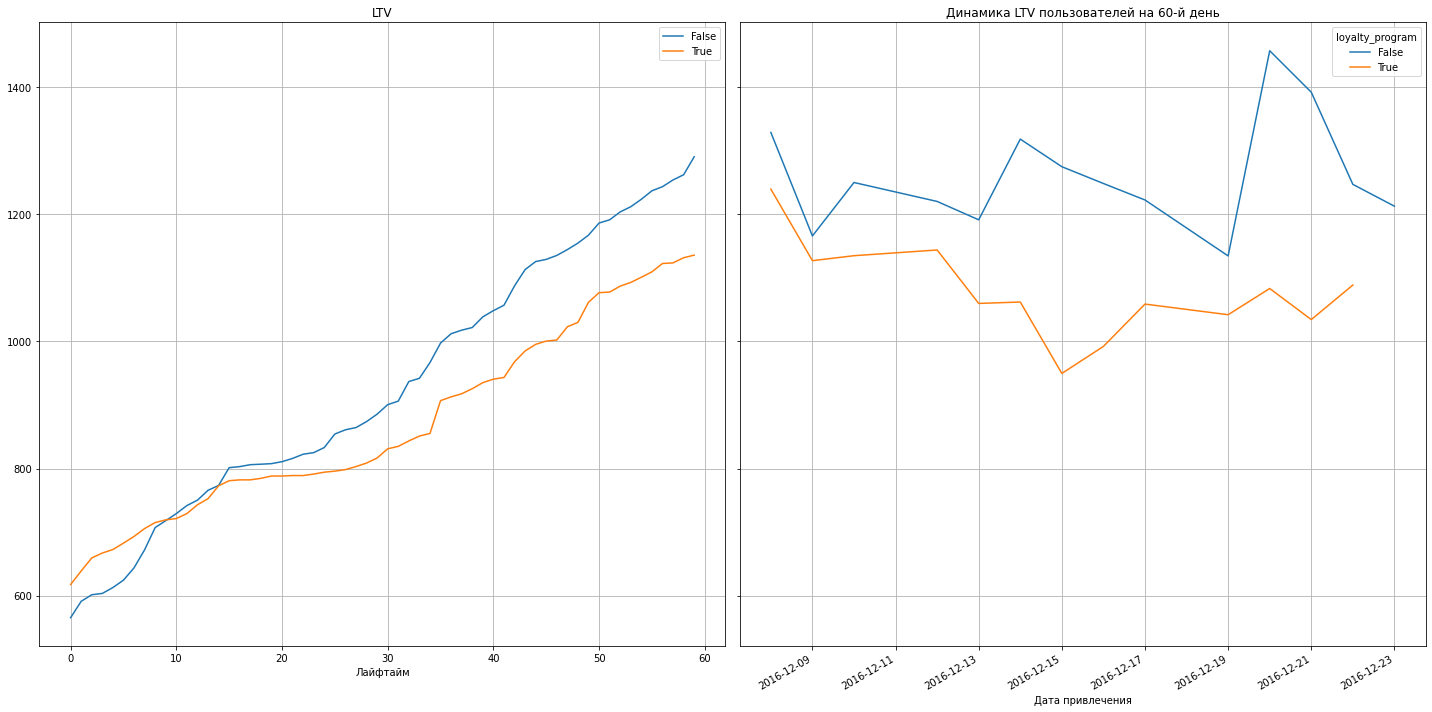

In [109]:
plot_ltv_roi(ltv, ltv_history, horizon_days, window=7)

LTV, или Lifetime Value, — это «пожизненная ценность» клиента, то есть общая сумма денег, которую один клиент в среднем приносит компании со всех своих покупок. LTV покупателей, пользующихся программой лояльности, спустя 60 дней "жизни" как покупателя, составляет около 1170 рублей, а остальных покупателей - приближается к 1300 рублей. При этом в первую неделю LTV покупателей по программе лояльности немного превышает показатель остальных покупателей, что скорее всего обусловлено платой за участие в программе лояльности. В динамике LTV покупателей программы лояльности ниже, чем у остальных покупателей.

#### Количество покупок в разрезе магазинов 

In [110]:
data_group.groupby(['shop_id', 'loyalty_program']).agg({'customer_id' : 'nunique', 'purchase_id' : 'nunique'})

customer_id  purchase_id
shop_id loyalty_program                          
Shop 0  False                    940         1888
        True                     553         1097
Shop 1  False                     38           71
Shop 10 False                      8           12
Shop 11 False                      5            6
Shop 12 False                     10           16
Shop 13 False                      1            4
Shop 14 False                      3            4
Shop 15 False                      1            2
Shop 16 False                      3            3
Shop 17 False                      2            2
Shop 18 False                      5            8
Shop 19 False                      2            2
        True                       1            2
Shop 2  False                      7           17
Shop 20 False                      3            3
Shop 21 False                      1            1
Shop 22 False                      3            4
Shop 24 False                      1            1
Shop 26 False                      1            1
Shop 27 False                      1            1
Shop 28 True                       1            1
Shop 29 False                      1            1
Shop 3  False                      4           12
Shop 30 False                      1            1
Shop 4  False                     41           80
Shop 5  False                      3            4
Shop 6  False                      3           31
Shop 7  False                      7           10
Shop 8  False                     10           13
        True                       1            2
Shop 9  False                      2            4

Только в четырех филиалах магазина совершались покупки по программе лояльности: Shop 0, Shop 19, Shop 28, Shop 8

## Проверка статистических гипотез

In [111]:
# Наша таблица с информацией о чеках
data_group.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,total,loyalty_program,purchase_month
0,536365,7,33,2016-12-01,23529,Shop 0,186.50,True,2016-12-01
1,536366,2,10,2016-12-01,23529,Shop 0,19.80,True,2016-12-01
2,536367,12,71,2016-12-01,18726,Shop 0,285.49,False,2016-12-01
3,536368,4,11,2016-12-01,18726,Shop 0,96.09,False,2016-12-01
4,536369,1,2,2016-12-01,18726,Shop 0,13.20,False,2016-12-01


In [112]:
# Разбиваем таблицу на две по условию вхождения в программу лояльности
data_group_true = data_group.query('loyalty_program == True')
data_group_false = data_group.query('loyalty_program == False')

### Гипотеза №1

- H0: Средний чек участников программы лояльности и остальных покупателей совпадает
- H1: Средний чек участников программы лояльности и остальных покупателей различается

In [113]:
# Проверим наши распределения на нормальность
# Нулевая гипотеза: распределение нормальное
# Альтернативная гипотеза: распределение ненормальное
alpha = 0.05

results = st.shapiro(data_group_true['total'])
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
    
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


In [114]:
alpha = 0.05

results = st.shapiro(data_group_false['total'])
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
    
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Т.к. наши выборки распределены не нормально, то для проверки гипотез будем использовать непараметрический тест Уилкоксона-Манна-Уитни

In [115]:
alpha = 0.05

results = st.mannwhitneyu(data_group_false['total'], data_group_true['total'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  1.844321789774493e-09
Отвергаем нулевую гипотезу: разница статистически значима


Т.к. нулевую гипотезу о равенстве средних рейтингов мы отвергаем, у нас есть основания полагать, что средние чеки участников программы лояльности и остальных покупателей отличаются. Согласно графиков выше, средние чеки участников программы лояльности меньше.

### Гипотеза №2

- H0: Среднее количество наименований товаров в чеке участников программы лояльности и остальных покупателей совпадает
- H1: Среднее количество наименований товаров в чеке участников программы лояльности и остальных покупателей различается

In [116]:
# Проверим наши распределения на нормальность
# Нулевая гипотеза: распределение нормальное
# Альтернативная гипотеза: распределение ненормальное
alpha = 0.05

results = st.shapiro(data_group_true['item_id'])
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
    
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  4.005009841818419e-36
Отвергаем нулевую гипотезу: распределение не нормально


In [117]:
alpha = 0.05

results = st.shapiro(data_group_false['item_id'])
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
    
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Т.к. наши выборки распределены не нормально, то для проверки гипотез будем использовать непараметрический тест Уилкоксона-Манна-Уитни

In [118]:
alpha = 0.05

results = st.mannwhitneyu(data_group_false['item_id'], data_group_true['item_id'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.26515957226879194
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Т.к. нулевую гипотезу не получилось отвергнуть, у нас нет оснований полагать, что средние количества наименований товаров в чеке участников программы лояльности и остальных покупателей значимо отличаются.

## Вывод и рекомендации для заказчика

По результатам анализа можно сделать следующие выводы:
- После предварительной обработки датасета осталось 65714 наблюдений с 1 декабря 2016 года по 28 февраля 2017 года
- За три месяца было продано 583105 товаров 2755 уникальных наименований, что составляет 87.21% от всего ассортимента товаров магазина.
- Больше всего товаров было куплено 16 декабря 2016 года - 18874 единиц, меньше всего - 6 февраля 2017 года - 1620 единиц товара. В целом в декабре 2016 года отмечалась большая активность в покупке товаров, чем в январе и феврале 2017 года
- Топ-3 товаров по количеству продаж: "21212" - 5723 штуки, "85123A" - 5520 штук, "85099B" - 5508 штук.
- Всего за рассматриваемый период магазин посетило 1661 уникальных покупателей, которые в среднем совершали около двух покупок
- Всего в датасете представлено 29 филиалов магазина, самый крупный из них - магазин Shop 0, на долю которого приходится 90% всех покупок за рассматриваемый период

По программе лояльности:
- В программе лояльности приняли участие треть покупателей
- По результатам анализа можно сделать вывод, что программа лояльности в нынешнем виде неэффективна, основные продуктовые метрики для покупателей, пользующихся программой лояльности, стабильно ниже, чем у остальных покупателей (средний чек, среднее количество купленных товаров, LTV). Для лояльных клиентов отмечался небольшой перевес по разнообразию товаров в чеке, но в результате проверки гипотезы этот перевес оказался статистически незначимым.
- Рекомендуется подробней проанализовать первые недели февраля на предмет причин всплеска активности покупателей, входящих в группу лояльности
- В случае, если 0 в столбце 'quantity' означает подарок, стоит пересмотреть условия их дарения, т.к. они составляют около 30% проданных товаров.

## Материалы для коллег из коммерческого департамента

Ссылка на презентацию: <https://disk.yandex.ru/i/nD3vdiVe3u3h1g>